# Поиск выбросов (outliers)

In [2]:
import numpy as np
import pandas as pd
from math import radians, sin, cos, asin, sqrt
%matplotlib inline

vis_data = pd.read_csv("../data/train.csv", encoding = 'ISO-8859-1', low_memory = False)
vis_data = vis_data.drop(['violation_zip_code', 'clean_up_cost'], axis=1)
# latlons = pd.read_csv("./data/latlons.csv")
# vis_data = pd.concat([vis_data, latlons], axis=1)

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

# vis_data['distance'] = vis_data.apply(lambda row: 
#                                       haversine(lon1 = -83.045753, 
#                                                 lat1 = 42.331429,
#                                                 lon2 = row['lon'], 
#                                                 lat2 = row['lat']), 
#                                       axis=1)

## Поиск и удаление по порогу

Часто оказывается так, что при погружении в предметную область вы начинаете понимать, какие значения данные признаки могут принимать, а какие - не могут. Например, если нужно заплатить штраф, полезно будет проверить, нет ли в выборке значений штрафов, меньших, чем `0`:

In [3]:
np.sum(vis_data.fine_amount < 0)

0

Кроме этого, интересно посмотреть максимальное значение штрафа:

In [4]:
max_fine = np.max(vis_data.fine_amount)
max_fine

10000.0

И сколько раз и как часто такой штраф встречается в данных:

In [5]:
max_fine_count = np.sum(vis_data.fine_amount == max_fine)
max_fine_count, max_fine_count/vis_data.shape[0]

(357, 0.0014262542647799094)

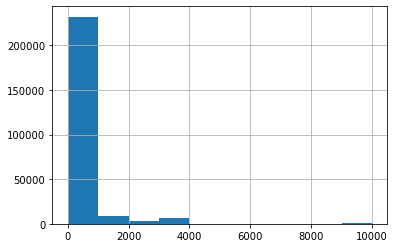

In [6]:
vis_data.fine_amount.hist();

Очень большое количество данных сосредоточено около 0. Посмотрим, сколько значений штрафов в выборке равно 0:

In [7]:
vis_data[vis_data.fine_amount == 0].shape[0]

195

Возможно, те значения, где размер штрафа равен 0, являются выбросами, если инспектор забыл добавить размер штрафа или ошибся при вводе.  
В таком случае эти значения следует убрать из выборки. В то же время, сложно однозначно сделать такое решение, не зная всей информации о данных.

Теперь посмотрим на данные поближе:

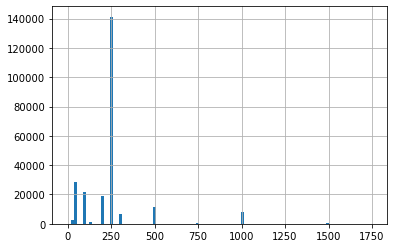

In [8]:
vis_data.fine_amount[vis_data.fine_amount < 2000].hist(bins=100);

Непохоже, что здесь есть выбросы (кроме нулевых штрафов), но можно категоризировать данные, заменив все значения больше 2000 на переменную `>2000` и сделав все остальные значения категориальными.

## Поиск по отклонению (z-score)
[Источник](http://colingorrie.github.io/outlier-detection.html)

Есть еще один способ поиска выбросов, не требующий настолько же пристального взгляда на данные, что и предыдущий метод.  
Он основан на поиске значения, на которое отклоняется данная точка от среднего. Делается это с помощью z-score, то есть, расстояния (измеряемого в количестве стандартных отклонений) от среднего значения точек.  
Для начала посмотрим на распределение данных для признака `distance`, который мы посчитали ранее:

In [9]:
import warnings

In [10]:
vis_data.distance.hist(bins=100);

AttributeError: 'DataFrame' object has no attribute 'distance'

Попытаемся "на глаз" определить порог, после которого мы считаем выбросы. Применим этот порог и посмотрим на количество "выбросов":

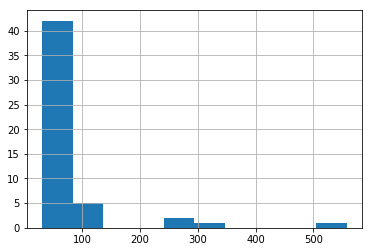

In [27]:
vis_data.distance[vis_data.distance > 30].hist();

In [11]:
def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    o = outliers_z_score(vis_data.distance)

In [13]:
len(o)

55

Значение по умолчанию для функции поиска выбросов равно `3`. Это означает, что мы считаем выбросами все, что находится на расстоянии больше 3 стандартных отклонений от среднего. Если мы подвигаем этот параметр в большую или меньшую сторону, мы найдем меньше или больше выбросов.

## IQR (interquartile range, межквартильное расстояние)

Один из способов - использовать перцентили (в данном случае квартили) для определения, где находятся выбросы. Для начала, посмотрим на `boxplot` для признака `distance`. Данный вид графика делит данные на 4 части. Та часть данных, которая отделена слева и справа двумя вертикальными линиями (находится внутри коробки) содержит 50% данных, так как левая линия обозначает первый квартиль (25-й перцентиль), а правая линия обозначает третий квартиль (75-й перцентиль).  
Большой вертикальной линией выделена медиана:

In [14]:
import seaborn as sns

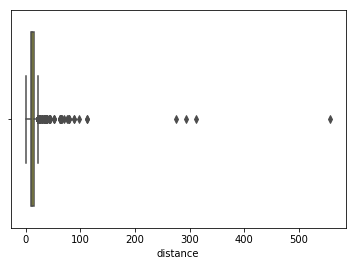

In [15]:
sns.boxplot(vis_data.distance, color='yellow');

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами коробки.  
Посмотрим, сколько выбросов он найдет:

In [16]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

Данный метод чувствителен к пропускам, поэтому избавимся от них:

In [17]:
o = outliers_iqr(vis_data.distance.dropna())

In [18]:
len(o)

134

## Поиск по распределению
[Источник](http://aqibsaeed.github.io/2016-07-17-anomaly-detection/)

Еще один способ найти выбросы - построить нормальное распределение поверх данных, посчитать вероятность находиться в данном распределении для каждого значения. Самые невероятные значения будем считать выбросами.

In [19]:
from scipy.stats import norm

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def get_gaussian(mu, sigma):
    distribution = norm(mu, sigma)
    return distribution

def get_probs(distribution, dataset):
    return distribution.pdf(dataset)

In [21]:
mu, sigma = estimate_gaussian(vis_data.distance.dropna())
distribution = get_gaussian(mu, sigma)
probabilities = get_probs(distribution, vis_data.distance.dropna())

Мы построили нормальное распределение на предоставленных данных и посчитали вероятность появления данной точки при данном распределении для каждого значения. Теперь выберем разумное значение вероятности, ниже которой будем считать точку выбросом. Например, `0.014`:

In [22]:
o_1 = np.where(probabilities < 0.014)[0]

In [23]:
len(o_1)

58

## DBSCAN

Алгоритм кластеризации DBSCAN определяет группы (кластеры) объектов. Его особенностью является то, что кроме самих кластеров он хорошо находит отдельно стоящие элементы, "шум". Применим его для нахождения выбросов. 

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

`DBSCAN` работает очень медленно, поэтому мы возьмем не все данные:

In [31]:
vis_data.shape

(250306, 36)

In [28]:
normalized_dist = np.random.choice(vis_data.distance.dropna().values, 
                                   50000).reshape(-1, 1)

In [29]:
db = DBSCAN(eps=0.5, min_samples=10).fit(normalized_dist)

Проверим количество выбросов:

In [30]:
len(np.where(db.labels_ == -1)[0])

22

## Проблемы с выбросами

Несмотря на то, что выбросы "портят" общую картину и заставляют статистики в данных (например, среднее) выглядеть неправильно, иногда они очень важны:

 - Если мы занимаемся поиском аномалий (Anomaly Detection), выбросы являются нашими зависимыми переменными, которые необходимо найти, а не значениями, которые нужно выбросить. Поиск аномалий выходит за рамки курса
 - Как можно было понять из методов выше, нет однозначного способа понять, что перед нами выброс. Разные методы возвращают разные точки в качестве выбросов, и эти точки пересекаются лишь частично. Кроме этого, разные параметры дают разные результаты и эти параметры необходимо крутить руками. Из-за этого найденные выбросы является крайне субъективным результатом